AIM: processing of the DTU/TUM data

In [1]:
# standart librairies
import os,sys
import numpy as np
import xarray as xr
import pandas as pd
import datetime

# plot
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import ticker

from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
CB_colors = {
	'blue':	'#377eb8',
	'orange':  '#ff7f00',
	'green':   '#4daf4a',
	'pink':	'#f781bf',
	'brown':   '#a65628',
	'purple':  '#984ea3',
	'gray':	'#999999',
	'red': 	'#e41a1c',
	'yellow':  '#dede00'
}

In [3]:
from dask.distributed import Client
c = Client()
c

/linkhome/rech/genlop01/uor98hu/.local/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46165 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46165/status,
Dashboard: http://127.0.0.1:46165/status,Workers: 5
Total threads: 10,Total memory: 20.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37985,Workers: 5
Dashboard: http://127.0.0.1:46165/status,Total threads: 10
Started: Just now,Total memory: 20.00 GiB
Comm: tcp://127.0.0.1:40955,Total threads: 2
Dashboard: http://127.0.0.1:46785/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:38625,


# loading DTU/TUM arctic data

In [4]:
# first manipulations of the dataset for ease: coordinates

chunk_size = {'lat':25,'lon':80}
diri = '/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/DTU_TUM/'
namo = 'cci_dtu_tum_arctic_sla_v3.1.nc'
DTUdat = xr.open_dataset(diri+namo,chunks=chunk_size)
#sept 1991 to sept 2018: change time unit
time = pd.date_range(start='09/1991', end='10/2018', freq='M')
DTUdata = DTUdat.rename({'t':'time_counter', 'lat':'y', 'lon':'x'})
# create mesh grid as coordinates
xx,yy = np.meshgrid(np.unique(DTUdata.longitude),np.unique(DTUdata.latitude))
longs =xr.DataArray(xx, dims=('y','x'))
lats =xr.DataArray(yy, dims=('y','x'))
DTUdata = DTUdata.assign_coords(nav_lon=longs, nav_lat=lats, time_counter=time)


In [5]:
sla = DTUdata.sea_level_anomaly
sla

<xarray.DataArray 'sea_level_anomaly' (time_counter: 325, x: 720, y: 67)>
dask.array<open_dataset-81ae5a3ce10cf480240a020689785d42sea_level_anomaly, shape=(325, 720, 67), dtype=float32, chunksize=(325, 80, 25), chunktype=numpy.ndarray>
Coordinates:
    nav_lon       (y, x) float32 -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
    nav_lat       (y, x) float32 65.0 65.0 65.0 65.0 ... 81.5 81.5 81.5 81.5
  * time_counter  (time_counter) datetime64[ns] 1991-09-30 ... 2018-09-30
Dimensions without coordinates: x, y
Attributes:
    units:         meter
    long_name:     Sea Level Anomaly
    comment:       meters above DTU18 MSS. The dimentions are given as (time,...
    grid_mapping:  latitude_longitude
    coordinates:   date lon lat

# correct the SLa from the product Mean sea level (regional)

In [13]:
def getAreaFactor(rlats,rlons):
    #lat, lon increaments in radians
    rdeltalat = abs(rlats[0]-rlats[1])
    rdeltalon = abs(rlons[0]-rlons[1])
    #nb of elements in the horizonally interpolated grid
    nlats = len(rlats)
    nlons = len(rlons)
    #variable area grid cells extending in the meridional direction
    Rt = 6370.0e3 # rayon de la terre em m
    latAreas = np.zeros(nlats)
    for ilat in np.arange(0,nlats):
        latAreas[ilat] = Rt*Rt*rdeltalon*(np.sin(rlats[ilat]+rdeltalat/2.) - np.sin(rlats[ilat]-rdeltalat/2.))
    #set all of them to every longitude
    Afac = np.broadcast_to(latAreas,(nlons,nlats)).T
    return Afac

### construct the "global" weight 

In [14]:
# 720 points de lon de -180 à 180
# 67 points de 65 °N à 81.5°N
# building the wheight for the DTU/DTU data grid 

longs = DTUdata.longitude 
lats = DTUdata.latitude

#convert in radians
rlons = np.pi*(longs)/180
rlats = np.pi*(lats)/180

afactors = getAreaFactor(rlats,rlons)

num_missing = np.isnan(sla).sum('time_counter')
#points that are always missing are land points (bool) (true for land points)
land_mask = num_missing == np.shape(sla.time_counter)[0]
afactors_masked = np.ma.masked_array(afactors, land_mask.T)
# correct area in the individual grid cells, nan over land cells
# compute the weight that must be used for the ocean cells alone. We must renormalize because we are just 
# taking the ones over the ocean now
areaWeights = afactors_masked/afactors_masked.sum() # total_area_ocean = afactors_masked.sum()
areaWeights = areaWeights.filled(np.nan)

# converting to dataArray:
daareaWeights = xr.DataArray(data=areaWeights.data, dims=["y", "x"])

In [24]:
RMSL = (sla*daareaWeights).sum(('x','y')).compute()

In [27]:
ds_rmsl = RMSL.to_dataset(name='RMSL')
ds_rmsl.to_netcdf("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/DTU_TUM/cci_dtu_tum_arctic_RMSL.nc", mode='w') 

In [29]:
sla_corrected = sla - RMSL

In [30]:
sla_corrected

<xarray.DataArray (time_counter: 325, x: 720, y: 67)>
dask.array<sub, shape=(325, 720, 67), dtype=float64, chunksize=(325, 80, 25), chunktype=numpy.ndarray>
Coordinates:
    nav_lon       (y, x) float32 -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
    nav_lat       (y, x) float32 65.0 65.0 65.0 65.0 ... 81.5 81.5 81.5 81.5
  * time_counter  (time_counter) datetime64[ns] 1991-09-30 ... 2018-09-30
Dimensions without coordinates: x, y

## Apply the BGRmaskDTU to DTU sla  and do the time series on the box

In [31]:
BGRmaskDTU = xr.open_dataset('/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/DTU_TUM/cci_dtu_tum_arctic_BGRmaskfull_grid.nc').BGRmaskDTU.squeeze()

# sla_box = sla.where((longs<-130) & (longs>-170) & (lats<81) & (lats>70),drop=True).fillna(0)

# pas corrigée du RMSL
# sla_boxmasked = sla.where(BGRmaskDTU)
# sla_boxmasked_1y = sla_boxmasked.sel(time_counter=slice('1992','2017')).groupby('time_counter.year').mean('time_counter')

# RMSL corrected version
sla_boxmasked = sla_corrected.where(BGRmaskDTU)
sla_boxmasked_1y = sla_boxmasked.sel(time_counter=slice('1992','2017')).groupby('time_counter.year').mean('time_counter')


In [32]:
# building the weight for the DTU/DTU data grid 

longs_box = DTUdata.longitude 
lats_box = DTUdata.latitude

#convert in radians
rlons = np.pi*(longs_box)/180
rlats = np.pi*(lats_box)/180

afactors = getAreaFactor(rlats,rlons)

num_missing = np.isnan(sla_boxmasked).sum('time_counter')
#points that are always missing are land points (bool) (true for land points)
land_mask = num_missing == np.shape(sla_boxmasked.time_counter)[0]
afactors_masked = np.ma.masked_array(afactors, land_mask.T)
# correct area in the individual grid cells, nan over land cells
# compute the weight that must be used for the ocean cells alone. We must renormalize because we are just 
# taking the ones over the ocean now
areaWeights = afactors_masked/afactors_masked.sum() # total_area_ocean = afactors_masked.sum()
areaWeights = areaWeights.filled(np.nan)

# converting to dataArray:
daareaWeights = xr.DataArray(data=areaWeights.data, dims=["y", "x"])

In [34]:
# weighted mean in the BGRbox
sla_boxmasked_mean_1m = (sla_boxmasked*daareaWeights).sum(('y','x'))
sla_boxmasked_mean_1m = sla_boxmasked_mean_1m - sla_boxmasked_mean_1m.mean()

sla_boxmasked_mean_1y = (sla_boxmasked_1y*daareaWeights).sum(('y','x'))
sla_boxmasked_mean_1y = sla_boxmasked_mean_1y - sla_boxmasked_mean_1y.mean()

In [1]:
ds_ts_sla_box = sla_boxmasked_mean_1m.to_dataset(name='ts_sla_box')
ds_ts_sla_box.to_netcdf("/gpfswork/rech/cli/uor98hu/DATA4VALIDATION/DTU_TUM/cci_dtu_tum_arctic_sla_corrected_ts_BGRbox.nc", mode='w') 

NameError: name 'sla_boxmasked_mean_1m' is not defined

In [2]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/" # plot directory
namo = 'ts_1m_dtu_model.png'
print(namo)

fig,(ax1) = plt.subplots(nrows=1, ncols=1, sharex=True,figsize=(16,4), facecolor='none', dpi=72*2)

(ssh_1m*100).plot(ax=ax1, color='k', linewidth=2)
(sla_boxmasked_mean_1m*100).plot(ax=ax1, color=CB_colors['red'], linewidth=2)

plt.plot(time4plt,tr_ssh_1m, color='k', linestyle='dashed',linewidth=1.5)
plt.plot(time4plt,tr_sla_boxmasked_mean_1m, color=CB_colors['red'], linestyle='dashed',linewidth=1.5)

ax1.grid()
ax1.legend(['Model','Altimetry'],fontsize=14,loc="upper left") 
ax1.set_title('')
ax1.set_xlabel('Time',fontsize=14); 
ax1.set_ylabel('sla [cm]',fontsize=14)

lim1 = -22.5
lim2 = 22.5
ax1.set_ylim(lim1,lim2)

ax1.axvspan('2005-01', '2018-12', color="grey", alpha=0.1)


plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), pad_inches=0.1, bbox_inches='tight') #,edgecolor='none', bbox_inches='tight'
plt.close(fig)

ts_1m_dtu_model.png


NameError: name 'plt' is not defined

In [3]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/" # plot directory
namo = 'ts_1y_dtu_model.png'
print(namo)

fig,(ax1) = plt.subplots(nrows=1, ncols=1, sharex=True,figsize=(16,4), facecolor='none', dpi=72*2)

(ssh_1y*100).plot(ax=ax1, color='k', linewidth=2)
(sla_boxmasked_mean_1y*100).plot( ax=ax1, color=CB_colors['red'], linewidth=2)

ax1.grid()
ax1.legend(['Model','Altimetry'],fontsize=14,loc="upper left") 
ax1.set_title('')
ax1.set_xlabel('Time',fontsize=14); 
ax1.set_ylabel('sla [cm]',fontsize=14)

lim1 = -17
lim2 = 17
ax1.set_ylim(lim1,lim2)

ax1.axvspan(2005, 2018, color="grey", alpha=0.1)


plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), pad_inches=0.1, bbox_inches='tight') #,edgecolor='none', bbox_inches='tight'
plt.close(fig)

ts_1y_dtu_model.png


NameError: name 'plt' is not defined

### technique de la rolling mean

In [70]:
sshrllmean_1m = ssh_1m.rolling(time_counter=12).mean()

slarllmean_1m = sla_boxmasked_mean_1m.rolling(time_counter=12).mean()


ts_1yrollmean_dtu_model.png


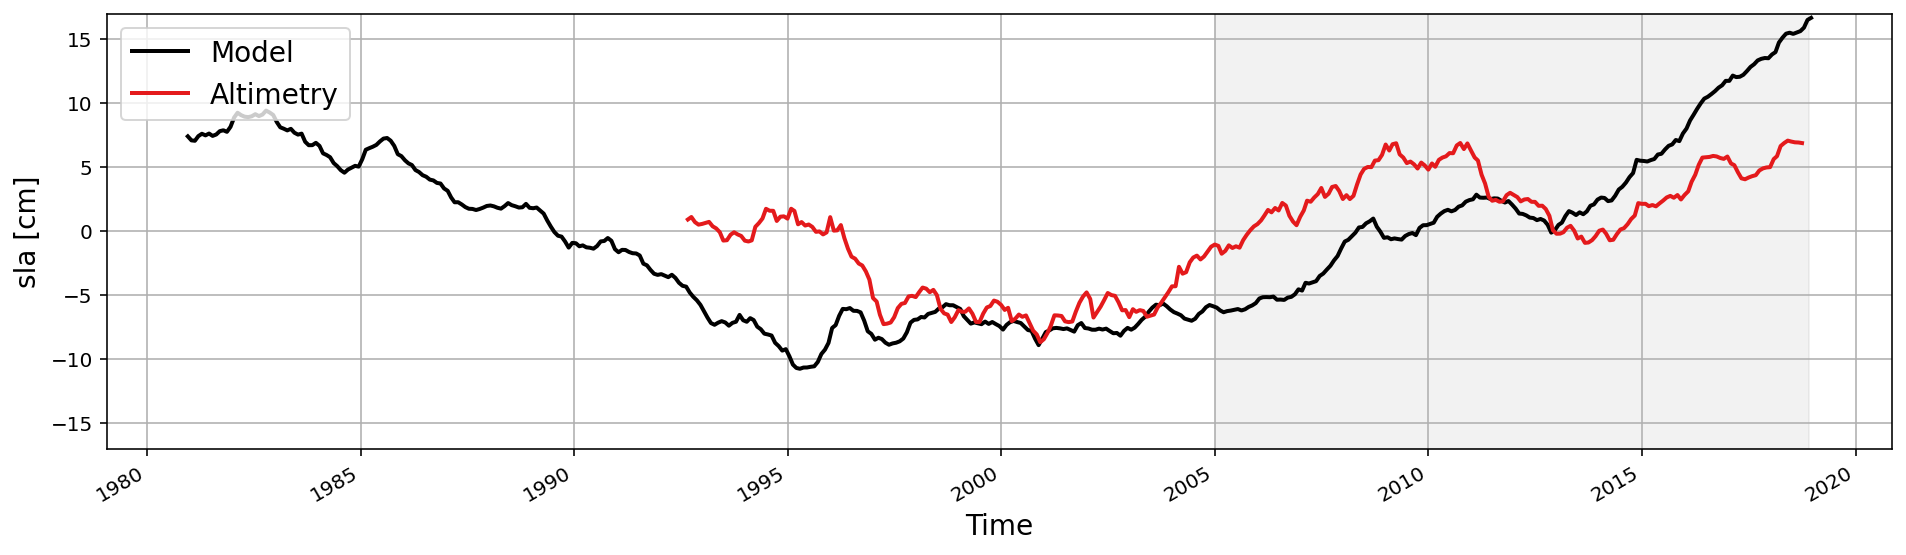

In [77]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/" # plot directory
namo = 'ts_1yrollmean_dtu_model.png'
print(namo)

fig,(ax1) = plt.subplots(nrows=1, ncols=1, sharex=True,figsize=(16,4), facecolor='none', dpi=72*2)

(sshrllmean_1m*100).plot(ax=ax1, color='k', linewidth=2)
(slarllmean_1m*100).plot(ax=ax1, color=CB_colors['red'], linewidth=2)

ax1.grid()
ax1.legend(['Model','Altimetry'],fontsize=14,loc="upper left") 
ax1.set_title('')
ax1.set_xlabel('Time',fontsize=14); 
ax1.set_ylabel('sla [cm]',fontsize=14)

lim1 = -17
lim2 = 17
ax1.set_ylim(lim1,lim2)

ax1.axvspan('2005-01', '2018-12', color="grey", alpha=0.1)


plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), pad_inches=0.1, bbox_inches='tight') #,edgecolor='none', bbox_inches='tight'
plt.close(fig)